In [2]:
import torch
import torch.nn as nn
import pyro
import pyro.distributions as dist
from torch.utils.data import DataLoader, TensorDataset
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from pyro.infer.mcmc import MCMC, NUTS
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt


def train_vae(model, train_loader, num_epochs=20, learning_rate=1e-3):
    pyro.clear_param_store()
    optimizer = Adam({"lr": learning_rate})
    svi = SVI(model.model, model.guide, optimizer, loss=Trace_ELBO())
    
    epoch_losses = []  # List to store the average loss per epoch
    
    for epoch in range(num_epochs):
        total_loss = 0.0
        for x_batch, in train_loader:
            loss = svi.step(x_batch)
            total_loss += loss
        avg_loss = total_loss / len(train_loader.dataset)
        
        predicted_y = model.reconstruct(x_batch)
        mse = torch.mean((x_batch - predicted_y) ** 2)
        epoch_losses.append(mse.item())  # Append the average loss
        print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}, MSE: {mse.item()}")

    # Plotting the loss
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs+1), epoch_losses, label='Average Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.title('Loss Progression over Epochs')
    plt.legend()
    plt.savefig('training_loss_progression.pdf')  # Save as PNG file
    
    
# 计算重构误差作为突变的指示
def compute_mutation_likelihood(model, x):
    model.eval()
    with torch.no_grad():
        recon_x = model.reconstruct(x)
        recon_error = nn.functional.mse_loss(recon_x, x, reduction='none')
        #recon_error = recon_error.mean(dim=1)  # 对基因取平均
        return recon_error.cpu().numpy(), recon_error.mean(dim=1).cpu().numpy()

def compute_gene_log_likelihoods(model, x, num_samples=10):
    model.eval()
    gene_log_likelihoods = []
    with torch.no_grad():
        for _ in range(num_samples):
            # 从后验分布中采样解码器参数
            fc1_weight = dist.Normal(pyro.param("fc1_weight_mu"), pyro.param("fc1_weight_sigma")).sample()
            fc1_bias = dist.Normal(pyro.param("fc1_bias_mu"), pyro.param("fc1_bias_sigma")).sample()
            fc2_weight = dist.Normal(pyro.param("fc2_weight_mu"), pyro.param("fc2_weight_sigma")).sample()
            fc2_bias = dist.Normal(pyro.param("fc2_bias_mu"), pyro.param("fc2_bias_sigma")).sample()

            # 前向传播
            z = model.encoder(x)
            h = torch.relu(torch.matmul(z, fc1_weight.t()) + fc1_bias)
            recon_x = torch.matmul(h, fc2_weight.t()) + fc2_bias

            # 计算对数似然（假设观测模型为正态分布，方差为1）
            log_probs = dist.Normal(recon_x, 1.0).log_prob(x)
            gene_log_likelihoods.append(log_probs.cpu().numpy())  # Shape: [num_samples, batch_size, num_genes]

    # 平均对数似然
    gene_log_likelihoods = np.array(gene_log_likelihoods)  # Shape: [num_samples, batch_size, num_genes]
    mean_log_likelihoods = np.mean(gene_log_likelihoods, axis=0)  # Shape: [batch_size, num_genes]
    return mean_log_likelihoods  # 返回每个样本、每个基因的平均对数似然

## Simple VAE

In [3]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, z_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, z_dim)      # Outputs mu
        self.fc_logvar = nn.Linear(hidden_dim, z_dim)  # Outputs log variance

    def forward(self, x):
        h = torch.relu(self.fc1(x))
        mu = self.fc_mu(h)
        log_var = self.fc_logvar(h)
        return mu, log_var

class Decoder(nn.Module):
    def __init__(self, z_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(z_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, z):
        h = torch.relu(self.fc1(z))
        recon_x = self.fc2(h)
        return recon_x

class VAE(nn.Module):
    def __init__(self, input_dim, z_dim=50, hidden_dim=400):
        super(VAE, self).__init__()
        self.encoder = Encoder(input_dim, hidden_dim, z_dim)
        self.decoder = Decoder(z_dim, hidden_dim, input_dim)
        self.input_dim = input_dim
        self.z_dim = z_dim

    def model(self, x):
        pyro.module("decoder", self.decoder)
        with pyro.plate("data", x.size(0)):
            # Prior over latent variable z
            z_prior = dist.Normal(torch.zeros(x.size(0), self.z_dim),
                                  torch.ones(x.size(0), self.z_dim)).to_event(1)
            z = pyro.sample("latent", z_prior)
            # Decode the latent variable
            recon_x = self.decoder(z)
            # Likelihood of the observed data
            pyro.sample("obs", dist.Normal(recon_x, 1.0).to_event(1), obs=x)

    def guide(self, x):
        pyro.module("encoder", self.encoder)
        with pyro.plate("data", x.size(0)):
            # Encode the observed data x
            mu, log_var = self.encoder(x)
            # Sample the latent variable z
            std = torch.exp(0.5 * log_var)
            z = pyro.sample("latent", dist.Normal(mu, std).to_event(1))

    def reconstruct(self, x):
        # Reconstruct x using the mean of q(z|x)
        mu, log_var = self.encoder(x)
        z = mu  # Use the mean as the representative latent variable
        recon_x = self.decoder(z)
        return recon_x
    
import numpy as np
import torch
import pyro.distributions as dist

def compute_gene_log_likelihoods(model, x, num_samples=10):
    model.eval()
    gene_log_likelihoods = []
    with torch.no_grad():
        for _ in range(num_samples):
            # Encode the data to get parameters of q(z|x)
            mu, log_var = model.encoder(x)
            std = torch.exp(0.5 * log_var)
            # Sample z from the approximate posterior q(z|x)
            z = mu + std * torch.randn_like(std)
            # Decode to get reconstructed x
            recon_x = model.decoder(z)
            # Compute log likelihood (assuming Normal likelihood with unit variance)
            log_probs = dist.Normal(recon_x, 1.0).log_prob(x)
            gene_log_likelihoods.append(log_probs.cpu().numpy())  # Shape: [batch_size, num_genes]

    # Average log likelihoods over samples
    gene_log_likelihoods = np.array(gene_log_likelihoods)  # Shape: [num_samples, batch_size, num_genes]
    mean_log_likelihoods = np.mean(gene_log_likelihoods, axis=0)  # Shape: [batch_size, num_genes]
    return mean_log_likelihoods  # Returns average log likelihood for each sample and gene

# 定义Pyro模型函数
def model_pyro(x, model, latent_dim=50):
    z = pyro.sample("latent", dist.Normal(0, 1).expand([latent_dim]).to_event(1))
    recon_x = model.decoder(z)
    pyro.sample("obs", dist.Normal(recon_x, 1.0).to_event(1), obs=x)

## Simple VAE + decoder mu sigma

In [4]:
import random

# 设置所有相关随机种子
np.random.seed(42)
random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

# 强制使用确定性算法
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.set_num_threads(1)
torch.use_deterministic_algorithms(True)  # 需要 PyTorch 1.8 或更高版本

# 设置 Pyro 随机种子
pyro.set_rng_seed(42)

In [5]:
df = pd.read_csv('/kaggle/input/paper-1/data.csv')
gene_ids = df.columns[14:].tolist()

def extract_test(df, group='1w'):
    df_test = df[df.group==group]
    df_test.reset_index(inplace=True,drop=True)
    df_test_ids = df_test['Unnamed: 0'].tolist()
    df_test = df_test.iloc[:, 14:]
    tensor_test = torch.tensor(df_test.values, dtype=torch.float32)
    return tensor_test, df_test_ids

tensor_train, _ = extract_test(df, group='control')
print(tensor_train.size())

torch.Size([10, 13774])


Epoch 1, Loss: 116854.0336, MSE: 14.892419815063477
Epoch 2, Loss: 114943.6512, MSE: 14.574070930480957
Epoch 3, Loss: 112413.8860, MSE: 14.03685188293457
Epoch 4, Loss: 108830.9446, MSE: 13.329732894897461
Epoch 5, Loss: 104311.6447, MSE: 12.52104377746582
Epoch 6, Loss: 98539.9853, MSE: 11.597789764404297
Epoch 7, Loss: 92261.9689, MSE: 10.539655685424805
Epoch 8, Loss: 85219.4372, MSE: 9.471466064453125
Epoch 9, Loss: 78096.2743, MSE: 8.427600860595703
Epoch 10, Loss: 70834.5803, MSE: 7.344324111938477
Epoch 11, Loss: 63779.5129, MSE: 6.362039089202881
Epoch 12, Loss: 57098.5032, MSE: 5.434365749359131
Epoch 13, Loss: 50969.4067, MSE: 4.5984907150268555
Epoch 14, Loss: 45396.5097, MSE: 3.859731674194336
Epoch 15, Loss: 40530.3398, MSE: 3.2186391353607178
Epoch 16, Loss: 36344.8289, MSE: 2.675199031829834
Epoch 17, Loss: 32767.0691, MSE: 2.2206852436065674
Epoch 18, Loss: 29790.1894, MSE: 1.8652377128601074
Epoch 19, Loss: 27327.3267, MSE: 1.552505612373352
Epoch 20, Loss: 25300.2244

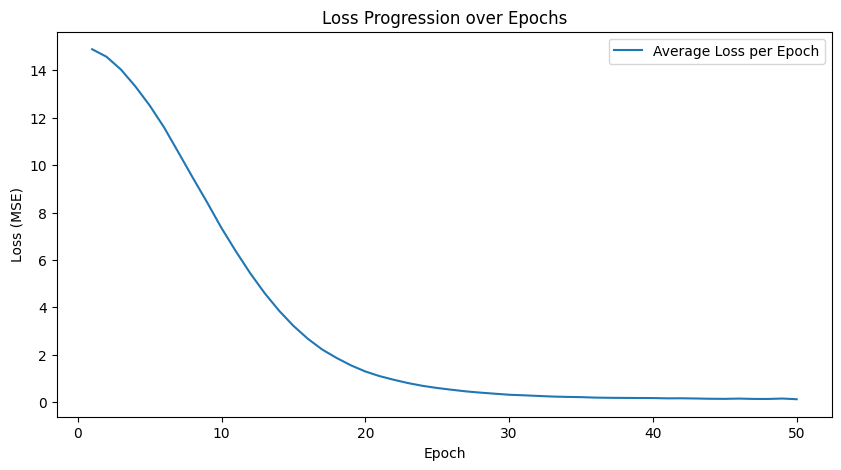

In [6]:
# 创建数据加载器
dataset = TensorDataset(tensor_train)
train_loader = DataLoader(dataset, batch_size=5, shuffle=True)

# 初始化模型
input_dim = len(gene_ids)
model = VAE(input_dim, z_dim=50, hidden_dim=500)

# 训练模型
train_vae(model, train_loader, num_epochs=50, learning_rate=1e-4)

# wt likelihoods
gene_log_likelihoods_wt = compute_gene_log_likelihoods(model, tensor_train, num_samples=100)

In [7]:
#pyro.param("fc1_weight_mu")#.item()
# 假设您的模型实例为 model
torch.save({
    'encoder_state_dict': model.encoder.state_dict(),
    'decoder_state_dict': model.decoder.state_dict(),
}, 'pytorch_model.pth')

pyro.get_param_store().save('pyro_params.save')


model = VAE(input_dim, z_dim=50, hidden_dim=500)
# 加载保存的状态字典
checkpoint = torch.load('pytorch_model.pth')

# 加载编码器和解码器的参数
model.encoder.load_state_dict(checkpoint['encoder_state_dict'])
model.decoder.load_state_dict(checkpoint['decoder_state_dict'])
pyro.get_param_store().load('pyro_params.save')

/tmp/ipykernel_31/2197264911.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('pytorch_model.pth')
/opt/conda/lib/python3.10/site-packages/pyro/p

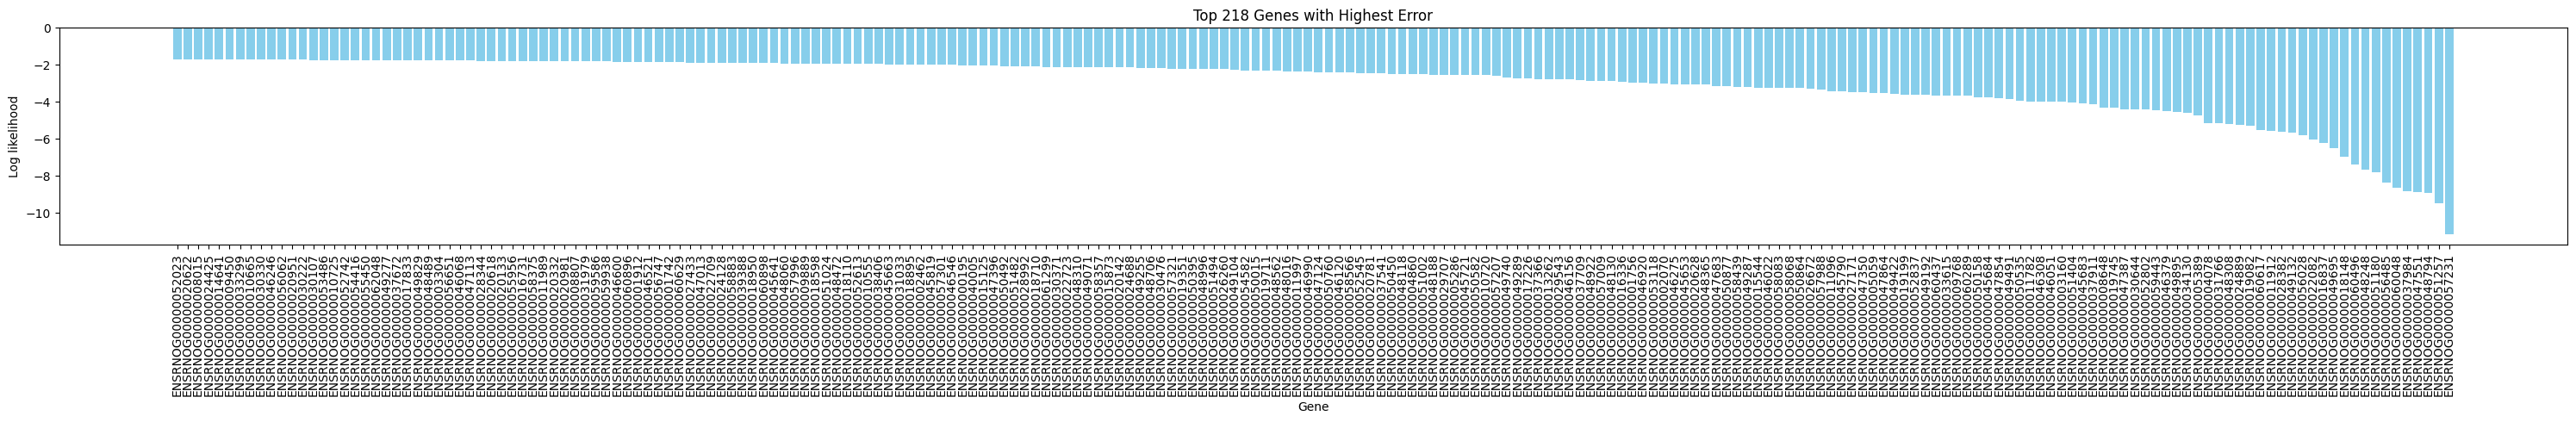

In [48]:
group4compare = '8w'

tensor_test, df_test_ids = extract_test(df, group=group4compare)
gene_log_likelihoods_mut = compute_gene_log_likelihoods(model, tensor_test, num_samples=1000)  # Shape: [num_mut_samples, num_genes]

gene_results = dict()
    
sample_level_gene_results = dict()
for sample_idx in range(gene_log_likelihoods_mut.shape[0]):
    sample_log_likelihoods = gene_log_likelihoods_mut[sample_idx]  # Shape: [num_genes]
    mean_ll = np.mean(sample_log_likelihoods)
    std_ll = np.std(sample_log_likelihoods)
    threshold = mean_ll - 3 * std_ll

    selected_genes = np.where(sample_log_likelihoods < threshold)[0]
    tmp_gene_idx_list = []
    #print(f"\nSample {df_test_ids[sample_idx]} - Genes (n={len(selected_genes)}) beyond 3 sigma:")
    for gene_idx in selected_genes:
        # print(f"Gene {gene_ids[gene_idx]}: Log-Likelihood = {sample_log_likelihoods[gene_idx]:.4f}")
        tmp_gene_idx_list.append([gene_ids[gene_idx], sample_log_likelihoods[gene_idx]])
        #print(f"{gene_ids[gene_idx]}")
    sample_level_gene_results[df_test_ids[sample_idx]] = tmp_gene_idx_list

gene_results['sample_level_results']=sample_level_gene_results
    
recon_error_wt, recon_error_mut = [], []
for i in range(10):
    avg_wt = sum(gene_log_likelihoods_wt[i]) / len(gene_log_likelihoods_wt[i])
    recon_error_wt.append(avg_wt)
    avg_mut = sum(gene_log_likelihoods_mut[i]) / len(gene_log_likelihoods_mut[i])
    recon_error_mut.append(avg_mut)

recon_errors = np.concatenate([recon_error_wt, recon_error_mut])
labels = np.array([0]*len(recon_error_wt) + [1]*len(recon_error_mut))

mean_gene_error_mut = np.mean(gene_log_likelihoods_mut, axis=0)  # Shape: [num_genes]
gene_error_difference = mean_gene_error_mut


mean_diff = np.mean(gene_error_difference)
std_diff = np.std(gene_error_difference)
threshold_upper = mean_diff - 2 * std_diff
top_N_genes = np.where(gene_error_difference < threshold_upper)[0]
N = len(top_N_genes)

top_N_genes_indices = np.argsort(gene_error_difference)[:N][::-1]
top_gene_names = [gene_ids[idx] for idx in top_N_genes_indices]# 提取基因名列表
top_values = [gene_error_difference[idx] for idx in top_N_genes_indices] # 提取对应的错误差异值列表


gene_results['group_level_results']=[[gene_ids[idx], gene_error_difference[idx]] for idx in top_N_genes_indices] 
gene_results['group_level_terms']=top_gene_names
gene_results['others'] = ['use top {N}']

plt.figure(figsize=(30, 5))
plt.bar(top_gene_names, top_values, color='skyblue')
plt.xlabel('Gene')
plt.ylabel('Log likelihood')
plt.title(f'Top {N} Genes with Highest Error')
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig(f"average_3sigma_genes_{group4compare}.pdf")
plt.show()
   
import json

class CustomEncoder(json.JSONEncoder):
    def default(self, obj):
        # Convert numpy float32 to Python float
        if isinstance(obj, np.float32):
            return float(obj)
        # Let the base class default method raise the TypeError
        return json.JSONEncoder.default(self, obj)
    
with open(f'res_{group4compare}.json', 'w') as file:
    json.dump(gene_results, file, cls=CustomEncoder)

In [9]:
# 3-sigma

for sample_idx in range(gene_log_likelihoods_mut.shape[0]):
    sample_log_likelihoods = gene_log_likelihoods_mut[sample_idx]  # Shape: [num_genes]
    
    # Compute mean and standard deviation of log-likelihoods for this sample
    mean_ll = np.mean(sample_log_likelihoods)
    std_ll = np.std(sample_log_likelihoods)
    
    # Calculate the threshold for 3-sigma
    threshold = mean_ll - 3 * std_ll
    
    # Identify genes whose log-likelihoods are more than 3 std deviations below the mean
    selected_genes = np.where(sample_log_likelihoods < threshold)[0]
    
    print(f"\nSample {df_test_ids[sample_idx]} - Genes (n={len(selected_genes)}) beyond 3 sigma:")
    for gene_idx in selected_genes:
        # Uncomment the next line if you want to see the log-likelihood values
        # print(f"Gene {gene_ids[gene_idx]}: Log-Likelihood = {sample_log_likelihoods[gene_idx]:.4f}")
        print(f"{gene_ids[gene_idx]}")


Sample 10025979 - Genes (n=108) beyond 3 sigma:
ENSRNOG00000001141
ENSRNOG00000001338
ENSRNOG00000001756
ENSRNOG00000001912
ENSRNOG00000002070
ENSRNOG00000002462
ENSRNOG00000003160
ENSRNOG00000004078
ENSRNOG00000005059
ENSRNOG00000008360
ENSRNOG00000008648
ENSRNOG00000009768
ENSRNOG00000011096
ENSRNOG00000011782
ENSRNOG00000011912
ENSRNOG00000013262
ENSRNOG00000015667
ENSRNOG00000016245
ENSRNOG00000016336
ENSRNOG00000016837
ENSRNOG00000017226
ENSRNOG00000018148
ENSRNOG00000018895
ENSRNOG00000018950
ENSRNOG00000019199
ENSRNOG00000019351
ENSRNOG00000019445
ENSRNOG00000019745
ENSRNOG00000020133
ENSRNOG00000020477
ENSRNOG00000020781
ENSRNOG00000020951
ENSRNOG00000020981
ENSRNOG00000022082
ENSRNOG00000022707
ENSRNOG00000022723
ENSRNOG00000024688
ENSRNOG00000024889
ENSRNOG00000026672
ENSRNOG00000027171
ENSRNOG00000029216
ENSRNOG00000029707
ENSRNOG00000030330
ENSRNOG00000030644
ENSRNOG00000031766
ENSRNOG00000032857
ENSRNOG00000033615
ENSRNOG00000033734
ENSRNOG00000033736
ENSRNOG00000037366
E

In [10]:
recon_error_wt, recon_error_mut = [], []
for i in range(10):
    numbers=gene_log_likelihoods_wt[i]
    average = sum(numbers) / len(numbers)
    recon_error_wt.append(average)
    print("wt平均值是：", average)
    numbers=gene_log_likelihoods_mut[i]
    average = sum(numbers) / len(numbers)
    recon_error_mut.append(average)
    print("mut平均值是：", average)

wt平均值是： -0.9791247767236836
mut平均值是： -1.0071199672071893
wt平均值是： -0.9770429995983593
mut平均值是： -0.9995761135111911
wt平均值是： -0.9991119438199497
mut平均值是： -1.0163765484490137
wt平均值是： -1.0004781485469347
mut平均值是： -1.0058843426214898
wt平均值是： -0.9936991475638274
mut平均值是： -1.014157974877516
wt平均值是： -0.9856181724057309
mut平均值是： -1.0122312100987416
wt平均值是： -0.9876937591382203
mut平均值是： -0.9980732619597982
wt平均值是： -0.984942786658435
mut平均值是： -0.9971150617191333
wt平均值是： -0.9859027126469978
mut平均值是： -1.0100841210043203
wt平均值是： -0.9842199242840282
mut平均值是： -1.013026297187639


Mean Error Difference: -1.0074
Standard Deviation: 0.3430

Top 218 abnormal genes based on reconstruction error difference:
ENSRNOG00000000195
ENSRNOG00000001742
ENSRNOG00000001756
ENSRNOG00000001912
ENSRNOG00000002070
ENSRNOG00000002462
ENSRNOG00000003160
ENSRNOG00000003304
ENSRNOG00000004078
ENSRNOG00000004860
ENSRNOG00000005059
ENSRNOG00000005286
ENSRNOG00000005389
ENSRNOG00000008015
ENSRNOG00000008648
ENSRNOG00000008807
ENSRNOG00000009450
ENSRNOG00000009768
ENSRNOG00000009889
ENSRNOG00000010555
ENSRNOG00000010665
ENSRNOG00000010720
ENSRNOG00000010725
ENSRNOG00000011096
ENSRNOG00000011782
ENSRNOG00000011912
ENSRNOG00000011989
ENSRNOG00000011997
ENSRNOG00000013262
ENSRNOG00000014641
ENSRNOG00000015125
ENSRNOG00000015544
ENSRNOG00000015873
ENSRNOG00000016336
ENSRNOG00000016731
ENSRNOG00000016837
ENSRNOG00000017226
ENSRNOG00000017833
ENSRNOG00000018110
ENSRNOG00000018148
ENSRNOG00000018598
ENSRNOG00000018710
ENSRNOG00000018895
ENSRNOG00000018950
ENSRNOG00000019082
ENSRNOG00000019199
EN

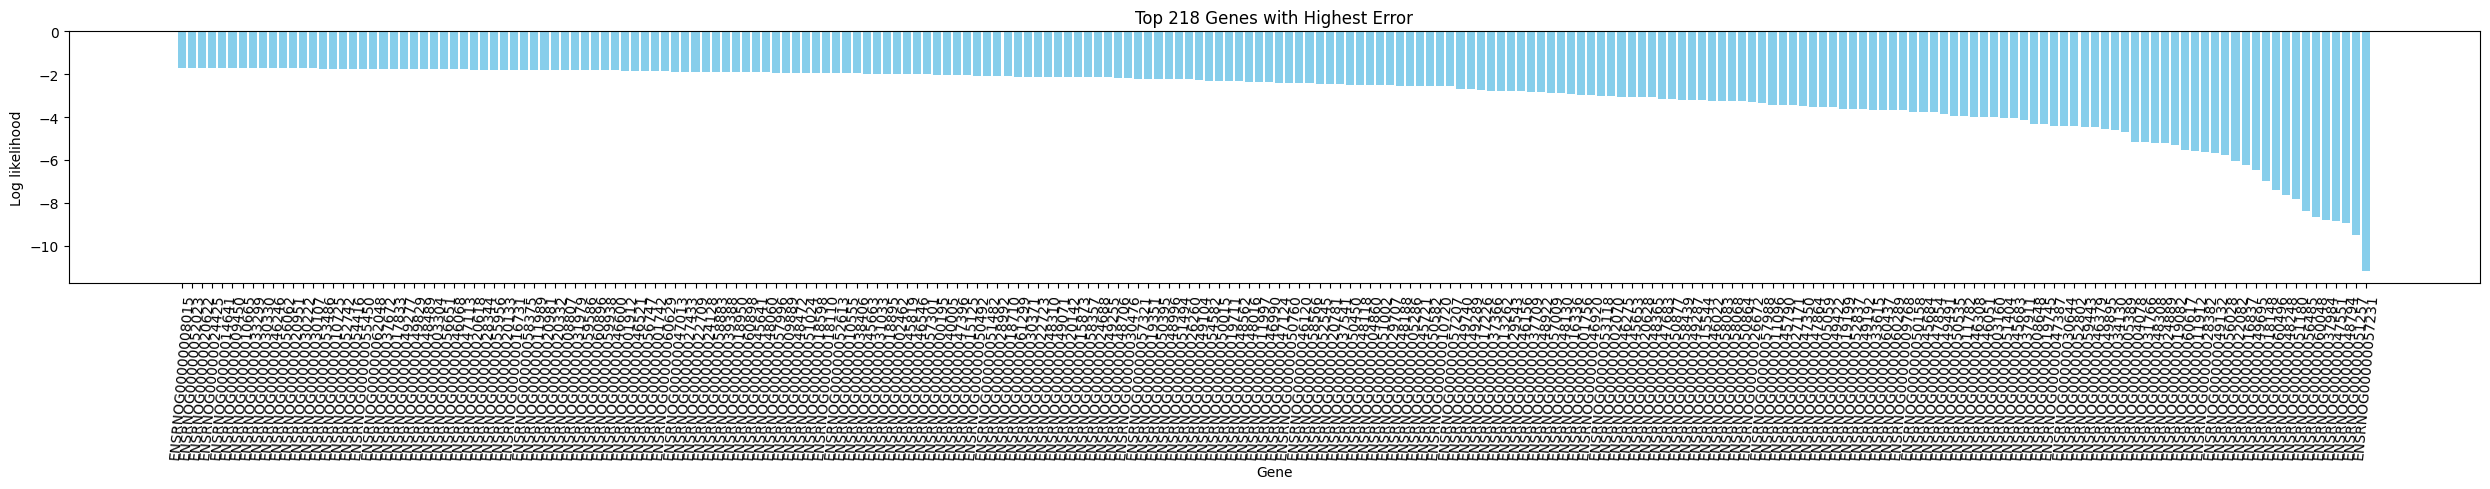

In [11]:
# 计算重构误差
#gene_errors_wt, recon_error_wt = compute_mutation_likelihood(model, tensor_train)
#gene_errors_mut, recon_error_mut = compute_mutation_likelihood(model, tensor_test)


# 合并误差和标签
recon_errors = np.concatenate([recon_error_wt, recon_error_mut])
labels = np.array([0]*len(recon_error_wt) + [1]*len(recon_error_mut))

# 合并数据
gene_errors = np.concatenate([gene_log_likelihoods_wt, gene_log_likelihoods_mut], axis=0)  # Shape: [total_samples, num_genes]
# 计算野生型和突变型样本中，每个基因的平均重构误差
mean_gene_error_wt = np.mean(gene_log_likelihoods_wt, axis=0)  # Shape: [num_genes]
mean_gene_error_mut = np.mean(gene_log_likelihoods_mut, axis=0)  # Shape: [num_genes]
# 计算突变型相对于野生型的误差增量
gene_error_difference = mean_gene_error_mut #- mean_gene_error_wt  # Shape: [num_genes]

flag_top = 0
if flag_top:
    # 选择误差增量最大的前 N 个基因
    N = 500
    top_N_genes = np.argsort(gene_error_difference)[:N]  # 获取基因索引
else:
    # 计算均值和标准差
    mean_diff = np.mean(gene_error_difference)
    std_diff = np.std(gene_error_difference)

    print(f"Mean Error Difference: {mean_diff:.4f}")
    print(f"Standard Deviation: {std_diff:.4f}")

    # 定义3σ阈值（仅筛选误差增量增加的基因）
    threshold_upper = mean_diff - 2 * std_diff

    # 筛选误差增量大于上阈值的基因索引
    top_N_genes = np.where(gene_error_difference < threshold_upper)[0]
    N = len(top_N_genes)


# 输出异常基因的信息
print(f"\nTop {N} abnormal genes based on reconstruction error difference:")
for idx in top_N_genes:
    print(f"{gene_ids[idx]}") #: Error Difference = {gene_error_difference[idx]:.4f}")
    #print(f"{gene_ids[idx]}")
    
top_N_genes_indices = np.argsort(gene_error_difference)[:N][::-1]
top_gene_names = [gene_ids[idx] for idx in top_N_genes_indices]# 提取基因名列表
top_values = [gene_error_difference[idx] for idx in top_N_genes_indices] # 提取对应的错误差异值列表



plt.figure(figsize=(25, 5))
plt.bar(top_gene_names, top_values, color='skyblue')
plt.xlabel('Gene')
plt.ylabel('Log likelihood')
plt.title(f'Top {N} Genes with Highest Error')
plt.xticks(rotation=85)
plt.tight_layout()
plt.savefig("average_3sigma_genes.pdf")
plt.show()
